In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
SCRNA_DIR = '../data/cao-2018/kidney/rna/'
SCATAC_DIR = '../data/cao-2018/kidney/atac/'

# scRNA-seq Data

In [4]:
%%time
scrna = sc.read_mtx(SCRNA_DIR + 'matrix.mtx').T
scrna.obs = pd.read_csv(SCRNA_DIR + 'obs.csv', index_col='sample')
scrna.var = pd.read_csv(SCRNA_DIR + 'var.csv', index_col='gene_id')
scrna

CPU times: user 13.2 s, sys: 3.23 s, total: 16.5 s
Wall time: 26.2 s


AnnData object with n_obs × n_vars = 13893 × 49584
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_name'
    var: 'gene_type', 'gene_short_name'

In [5]:
scrna.obs.head()

,source,replicate,experiment,tsne_1,tsne_2,cell_name
sample,,,,,,
coRNA-RNA-plate1-001.TCGGCGTCGT,Mouse,Replicate 1,coassay,NaN,NaN,NaN
coRNA-RNA-plate1-001.CATGACTCAA,Mouse,Replicate 1,coassay,2.808426,-45.948924,Loop of Henle cells
coRNA-RNA-plate1-001.CGCCAGGCAT,Mouse,Replicate 1,coassay,-4.660380,-41.004499,Loop of Henle cells
coRNA-RNA-plate1-001.CTGGTTGGTT,Mouse,Replicate 1,coassay,NaN,NaN,NaN
coRNA-RNA-plate1-001.CCAGGCTCTT,Mouse,Replicate 2,coassay,10.309332,11.143745,Proximal tubule S1/S2 cells


In [6]:
scrna.var.head()

,gene_type,gene_short_name
gene_id,,
ENSMUSG00000102693.1,TEC,4933401J01Rik
ENSMUSG00000064842.1,snRNA,Gm26206
ENSMUSG00000051951.5,protein_coding,Xkr4
ENSMUSG00000102851.1,processed_pseudogene,Gm18956
ENSMUSG00000103377.1,TEC,Gm37180


## Data Cleaning

In [7]:
scrna = scrna[~scrna.obs['cell_name'].isna()]

In [8]:
scrna.obs = scrna.obs.rename(columns={'cell_name': 'cell_type'})

In [9]:
scrna.obs['cell_type'] = scrna.obs['cell_type'].astype('category')

In [10]:
scrna.obsm['X_tsne'] = scrna.obs[['tsne_1', 'tsne_2']].to_numpy()

In [11]:
scrna

AnnData object with n_obs × n_vars = 10727 × 49584
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type'
    var: 'gene_type', 'gene_short_name'
    obsm: 'X_tsne'

# Quality Control

In [12]:
scrna.var_names_make_unique()

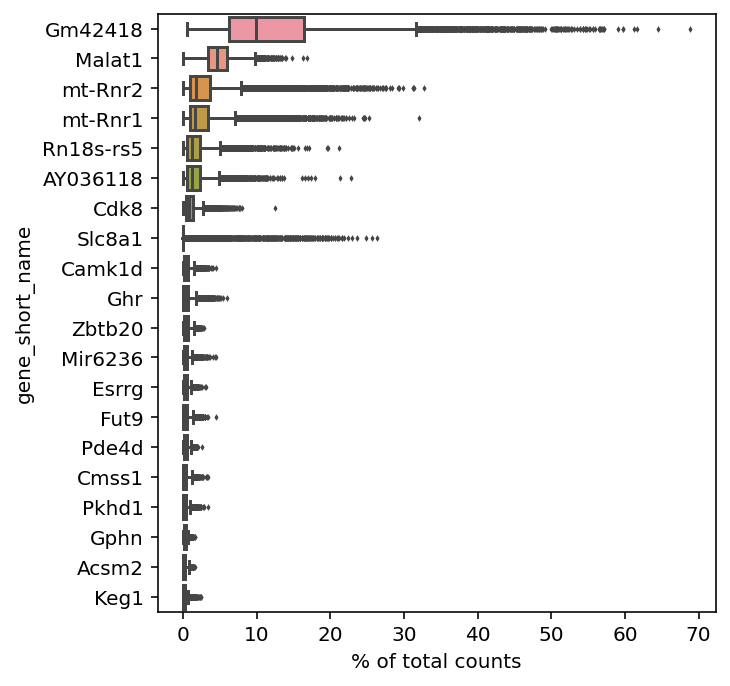

In [13]:
sc.pl.highest_expr_genes(scrna, n_top=20, gene_symbols='gene_short_name')

In [14]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna

AnnData object with n_obs × n_vars = 10548 × 23362
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes'
    var: 'gene_type', 'gene_short_name', 'n_cells'
    obsm: 'X_tsne'

## Qalculate QC metrics including Mitochondrial genes

In [15]:
scrna.var['mt'] = scrna.var['gene_short_name'].str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 10548 × 23362
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_tsne'

... storing 'source' as categorical
... storing 'replicate' as categorical
... storing 'experiment' as categorical
... storing 'gene_type' as categorical
... storing 'gene_short_name' as categorical


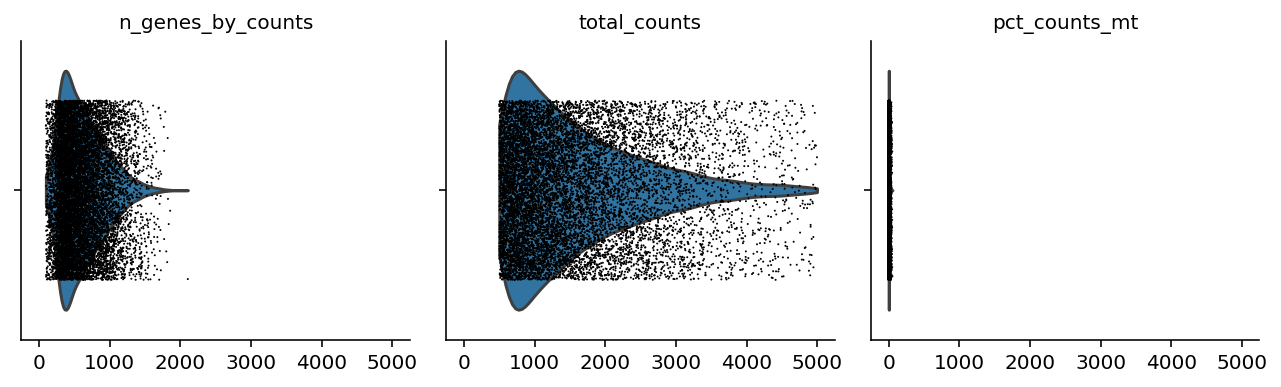

In [16]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

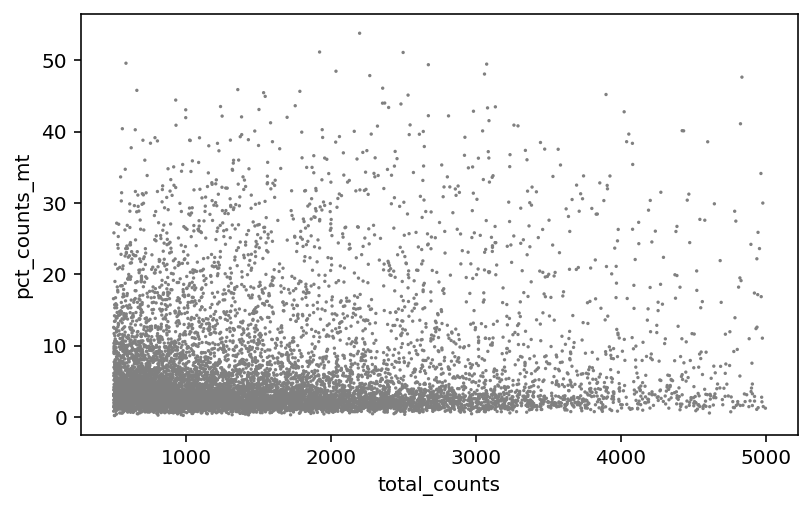

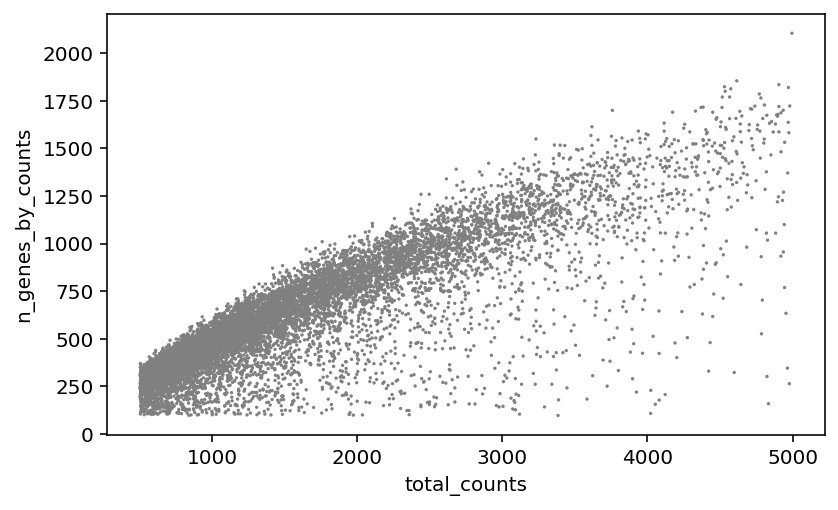

In [17]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

Filter out high mitochondrial samples and samples with highest number of genes:

In [18]:
scrna = scrna[scrna.obs.n_genes_by_counts < 1250, :]
scrna = scrna[scrna.obs.pct_counts_mt < 15, :]
scrna

View of AnnData object with n_obs × n_vars = 8992 × 23362
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_tsne'

In [19]:
%time scrna.write(SCRNA_DIR + 'expressions-raw.h5ad')

CPU times: user 167 ms, sys: 106 ms, total: 274 ms
Wall time: 734 ms


In [20]:
scrnaraw = scrna.copy()

## Normalization

In [21]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

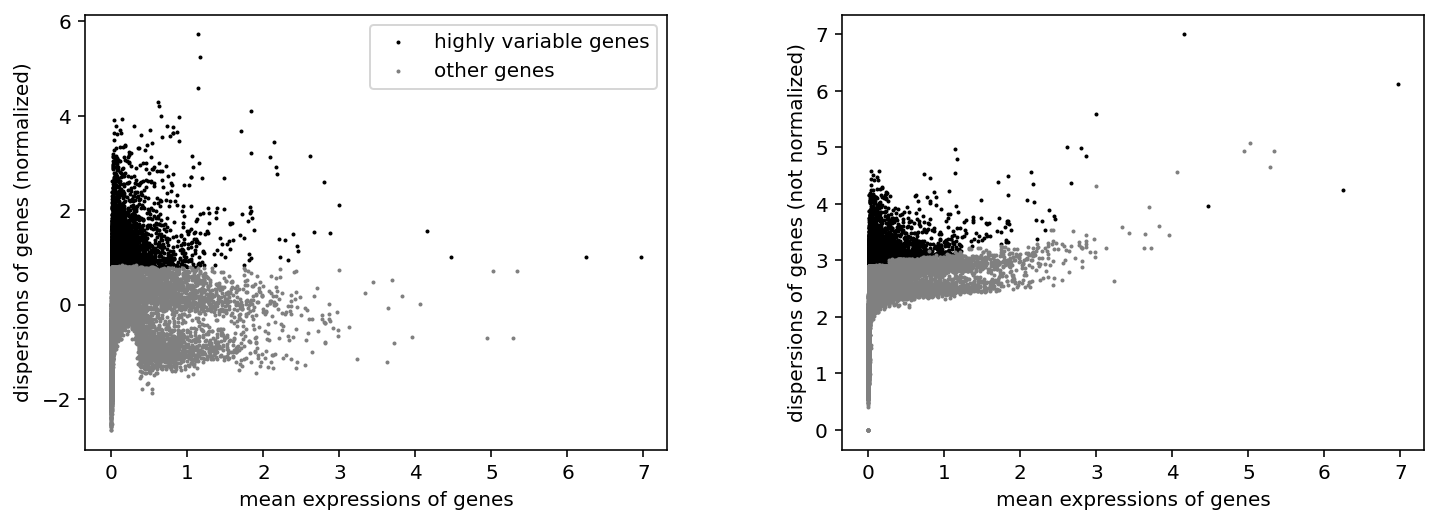

In [24]:
sc.pp.highly_variable_genes(scrna, n_top_genes=4000, batch_key='replicate')
sc.pl.highly_variable_genes(scrna)

In [25]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 8992 × 4000
    obs: 'source', 'replicate', 'experiment', 'tsne_1', 'tsne_2', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_type', 'gene_short_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p'
    obsm: 'X_tsne'

In [26]:
scrna.layers['count'] = scrnaraw[:, scrna.var.index].X.astype(np.uint8).copy()

## Visualization

### t-SNE using coordinates provided by the authors

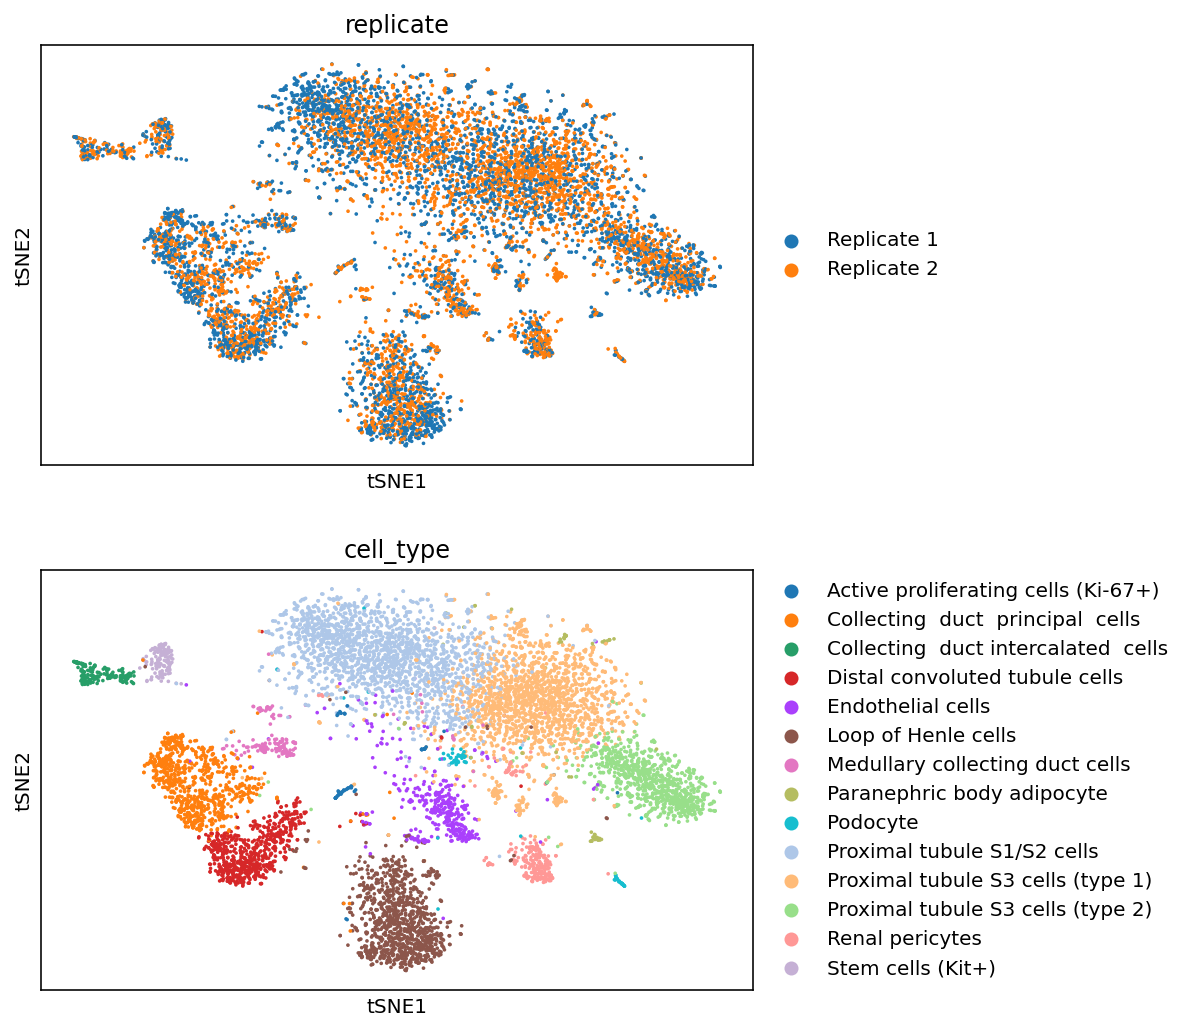

In [27]:
sc.pl.tsne(scrna, color=['replicate', 'cell_type'], ncols=1)

### Running UMAP

In [28]:
sc.pp.neighbors(scrna)
sc.tl.umap(scrna)

         Falling back to preprocessing with `sc.pp.pca` and default params.


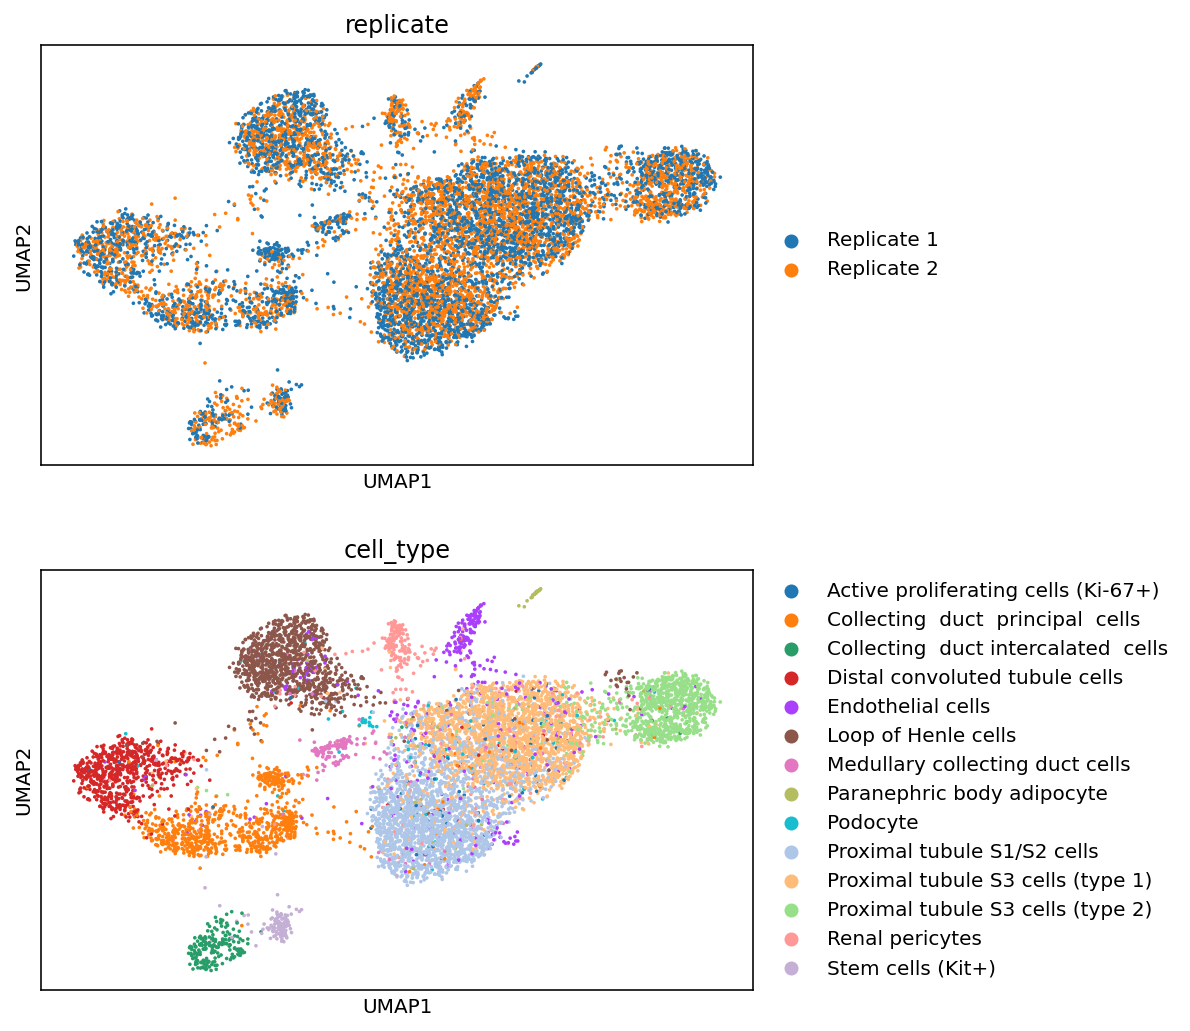

In [29]:
sc.pl.umap(scrna, color=['replicate', 'cell_type'], ncols=1)

---
# scATAC-seq Data

In [30]:
%%time
scatac = sc.read_mtx(SCATAC_DIR + 'matrix.mtx').T
scatac.obs = pd.read_csv(SCATAC_DIR + 'obs.csv', index_col='sample')
scatac.var = pd.read_csv(SCATAC_DIR + 'var.csv', index_col='peak')
scatac

CPU times: user 21 s, sys: 1.34 s, total: 22.3 s
Wall time: 37.9 s


AnnData object with n_obs × n_vars = 13395 × 252741
    obs: 'replicate'
    var: 'id', 'chr', 'start', 'end'

In [31]:
scatac.obs.head()

,replicate
sample,
coRNA-RNA-plate1-052.CGTAAGGAGT,Replicate 1
coRNA-RNA-plate1-052.ACTCCGCCAA,Replicate 1
coRNA-RNA-plate1-052.GGCTCGAGAT,Replicate 2
coRNA-RNA-plate1-052.CGCCAGGCAT,Replicate 1
coRNA-RNA-plate1-052.CATGACTCAA,Replicate 1


In [32]:
scatac.var.head()

,id,chr,start,end
peak,,,,
GL456210.1-58882-59082,1,GL456210.1,58882,59082
GL456210.1-110303-110503,2,GL456210.1,110303,110503
GL456210.1-123592-123792,3,GL456210.1,123592,123792
GL456210.1-136519-136719,4,GL456210.1,136519,136719
GL456210.1-147592-147792,5,GL456210.1,147592,147792


## Data Cleaning

In [33]:
scatac.obs = scatac.obs.join(scrna.obs, how='left', rsuffix='_rna')

In [34]:
scatac.obs = scatac.obs[['replicate', 'cell_type']]

In [35]:
scatac = scatac[~scatac.obs['cell_type'].isna()]

In [36]:
scatac.var = scatac.var.drop('id', axis=1)

In [37]:
scatac.obs.head()

,replicate,cell_type
sample,,
coRNA-RNA-plate1-052.CGTAAGGAGT,Replicate 1,Collecting duct principal cells
coRNA-RNA-plate1-052.GGCTCGAGAT,Replicate 2,Proximal tubule S1/S2 cells
coRNA-RNA-plate1-052.CGCCAGGCAT,Replicate 1,Collecting duct intercalated cells
coRNA-RNA-plate1-052.CATGACTCAA,Replicate 1,Proximal tubule S1/S2 cells
coRNA-RNA-plate1-052.AATCGAACTC,Replicate 2,Proximal tubule S1/S2 cells


In [38]:
scatac.var.head()

,chr,start,end
peak,,,
GL456210.1-58882-59082,GL456210.1,58882,59082
GL456210.1-110303-110503,GL456210.1,110303,110503
GL456210.1-123592-123792,GL456210.1,123592,123792
GL456210.1-136519-136719,GL456210.1,136519,136719
GL456210.1-147592-147792,GL456210.1,147592,147792


In [39]:
scatac

AnnData object with n_obs × n_vars = 7482 × 252741
    obs: 'replicate', 'cell_type'
    var: 'chr', 'start', 'end'

## Quality Control

### Basic filtering

In [40]:
epi.pp.filter_features(scatac, min_cells=1)
epi.pp.filter_cells(scatac, min_features=1)
scatac

AnnData object with n_obs × n_vars = 7482 × 248921
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells'

## Binarization

In [41]:
scatac.X.max()

5557.0

In [42]:
%time epi.pp.binarize(scatac)
scatac

CPU times: user 504 ms, sys: 16.7 ms, total: 520 ms
Wall time: 827 ms


AnnData object with n_obs × n_vars = 7482 × 248921
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells'

## Filter low quality cells and peaks

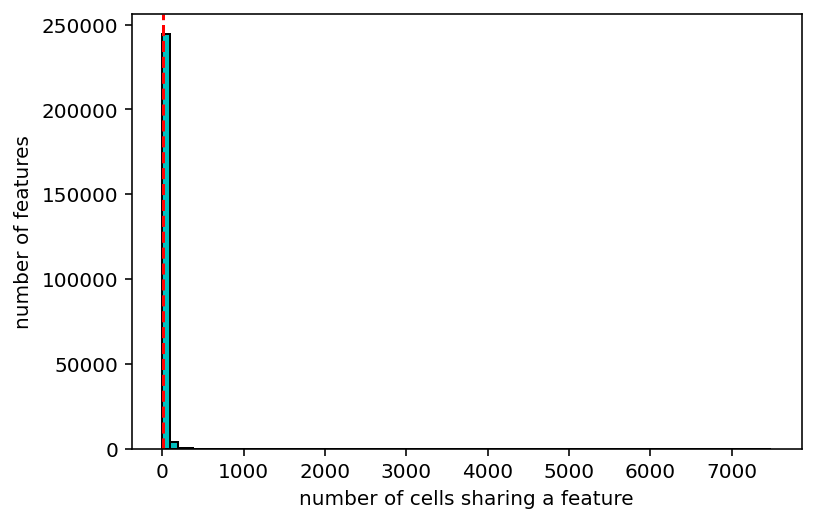

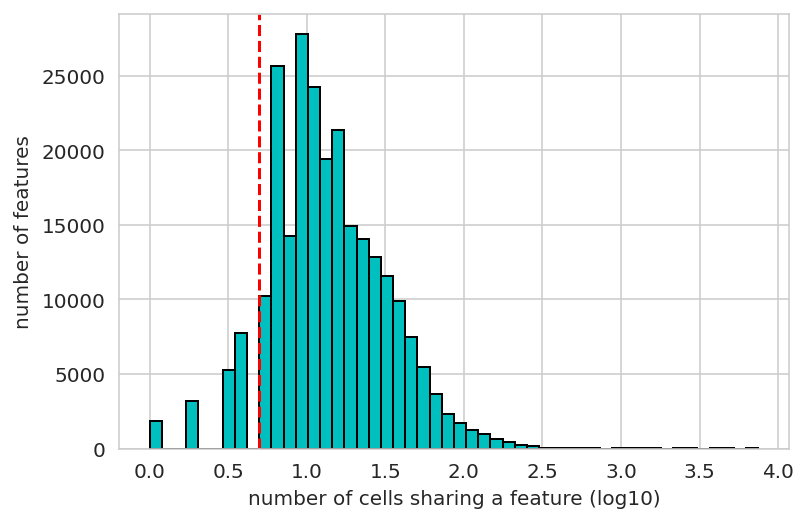

In [43]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=5)
epi.pp.coverage_features(scatac, binary=True, log=10, bins=50, threshold=5)

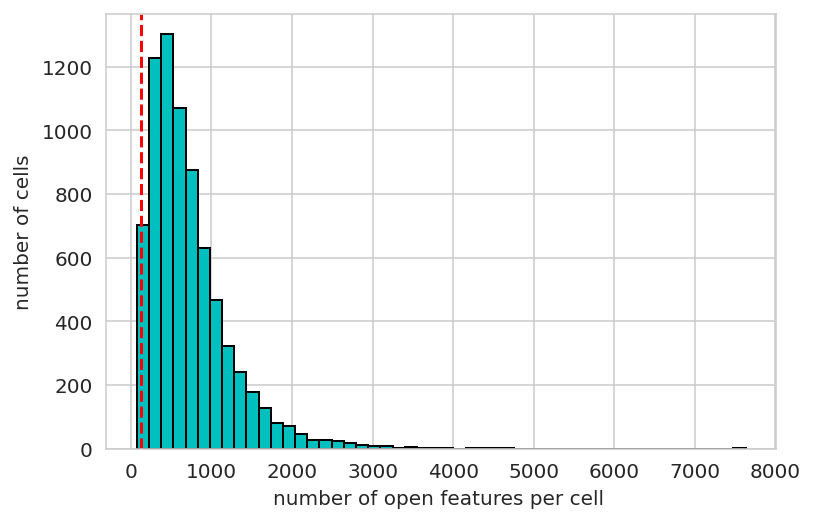

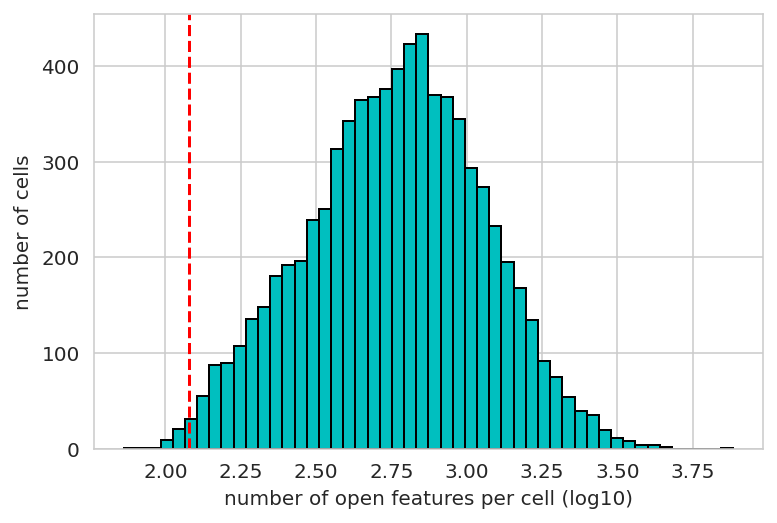

In [45]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=120)
epi.pp.coverage_cells(scatac, binary=True, log=10, bins=50, threshold=120)

In [46]:
epi.pp.filter_cells(scatac, min_features=120)
epi.pp.filter_features(scatac, min_cells=5)
scatac

AnnData object with n_obs × n_vars = 7439 × 230824
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells', 'commonness'

Filtering cells with high open peaks and peaks with high number of cells:

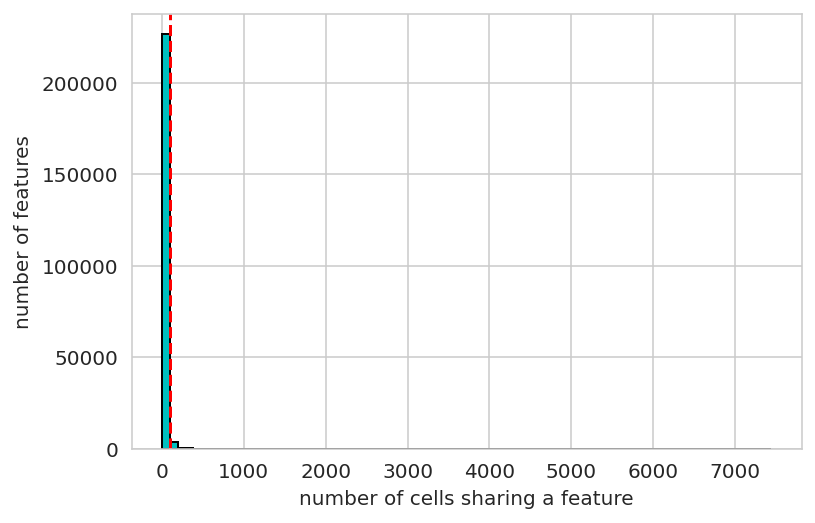

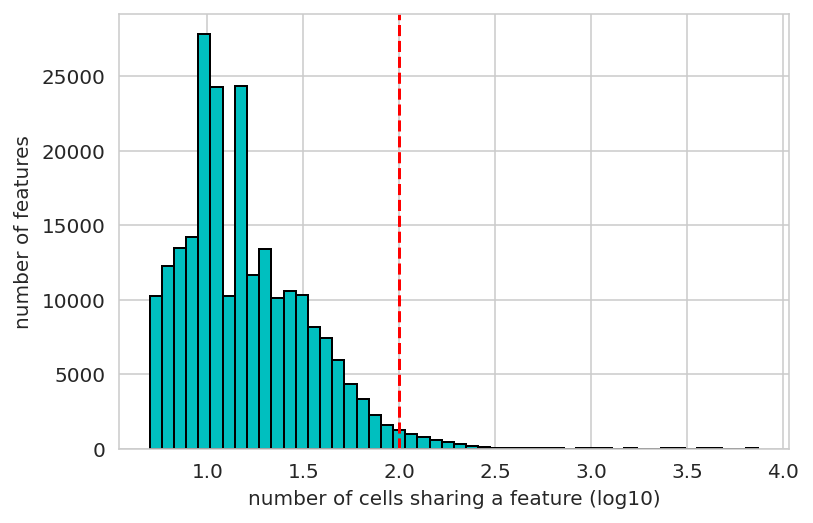

In [47]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=100)
epi.pp.coverage_features(scatac, binary=True, log=True, bins=50, threshold=100)

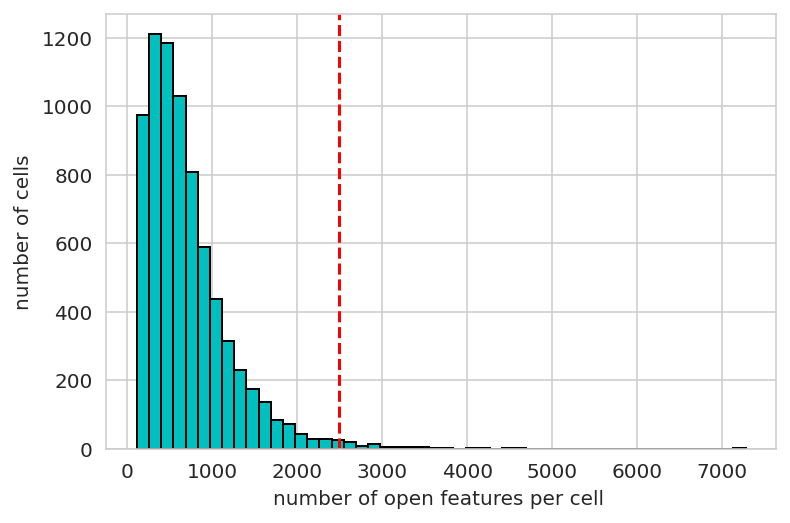

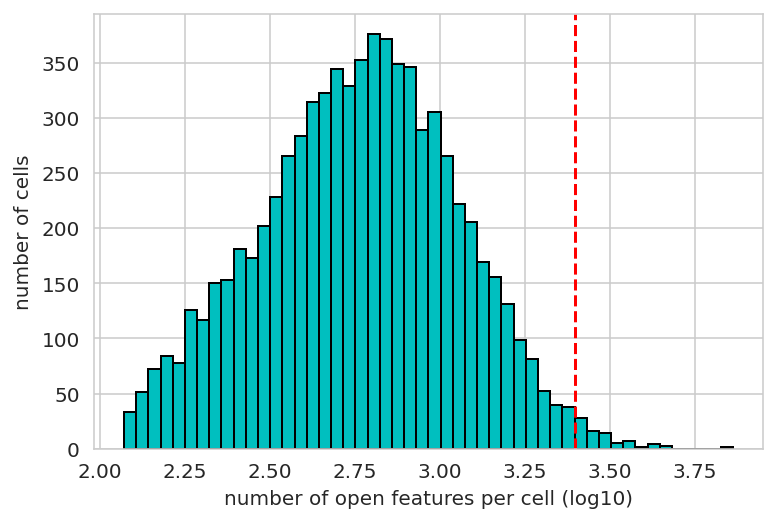

In [50]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=2500)
epi.pp.coverage_cells(scatac, binary=True, log=True, bins=50, threshold=2500)

In [51]:
epi.pp.filter_cells(scatac, max_features=2500)
epi.pp.filter_features(scatac, max_cells=100)
scatac

AnnData object with n_obs × n_vars = 7362 × 227035
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells', 'commonness'

In [52]:
scatac.obs['nb_features'].describe()

count    7362.000000
mean      692.564521
std       440.078503
min       118.000000
25%       366.250000
50%       588.000000
75%       908.000000
max      2492.000000
Name: nb_features, dtype: float64

In [53]:
scatac.var['commonness'].describe()

count    227035.000000
mean         19.472729
std          16.160899
min           5.000000
25%           9.000000
50%          14.000000
75%          24.000000
max         112.000000
Name: commonness, dtype: float64

In [54]:
scatac.var['commonness'].median()

14.0

In [55]:
scatac = scatac[:, scatac.var['commonness'] > scatac.var['commonness'].median()]
scatac

View of AnnData object with n_obs × n_vars = 7362 × 105364
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells', 'commonness'

In [56]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-raw.h5ad')

Trying to set attribute `.obs` of view, copying.
... storing 'replicate' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'chr' as categorical


CPU times: user 422 ms, sys: 38.3 ms, total: 460 ms
Wall time: 752 ms


## Selecting variable peaks

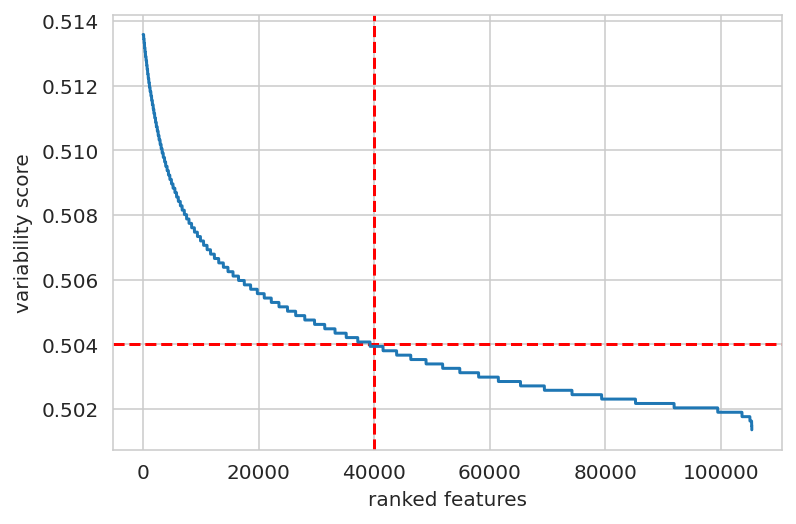

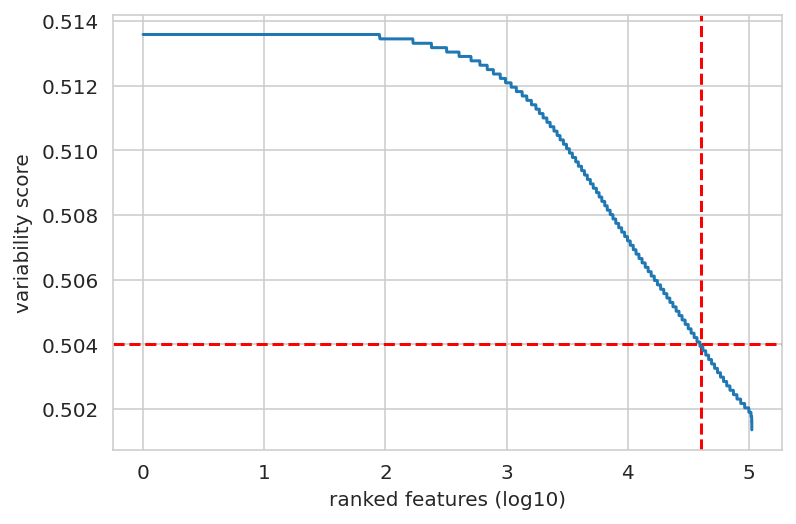

In [57]:
min_score_value = 0.504
nb_feature_selected = 40000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

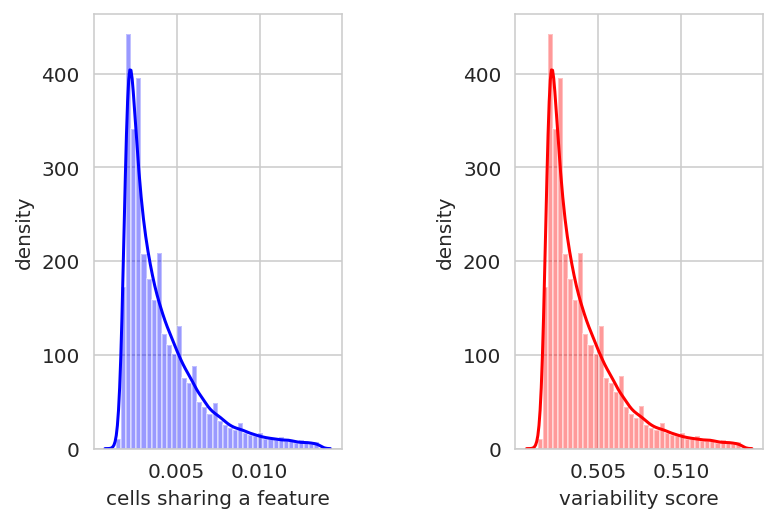

CPU times: user 1.76 s, sys: 503 ms, total: 2.26 s
Wall time: 2.3 s


In [58]:
%time epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected)

In [59]:
scatac

AnnData object with n_obs × n_vars = 7362 × 41524
    obs: 'replicate', 'cell_type', 'nb_features'
    var: 'chr', 'start', 'end', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [60]:
scatac.layers['binary'] = scatac.X.astype(np.uint8).copy()

## Normalization

In [61]:
epi.pp.normalize_total(scatac, target_sum=1e4)
epi.pp.log1p(scatac)

## Visualization

### Running UMAP

In [62]:
sc.pp.neighbors(scatac)
sc.tl.umap(scatac)

         Falling back to preprocessing with `sc.pp.pca` and default params.


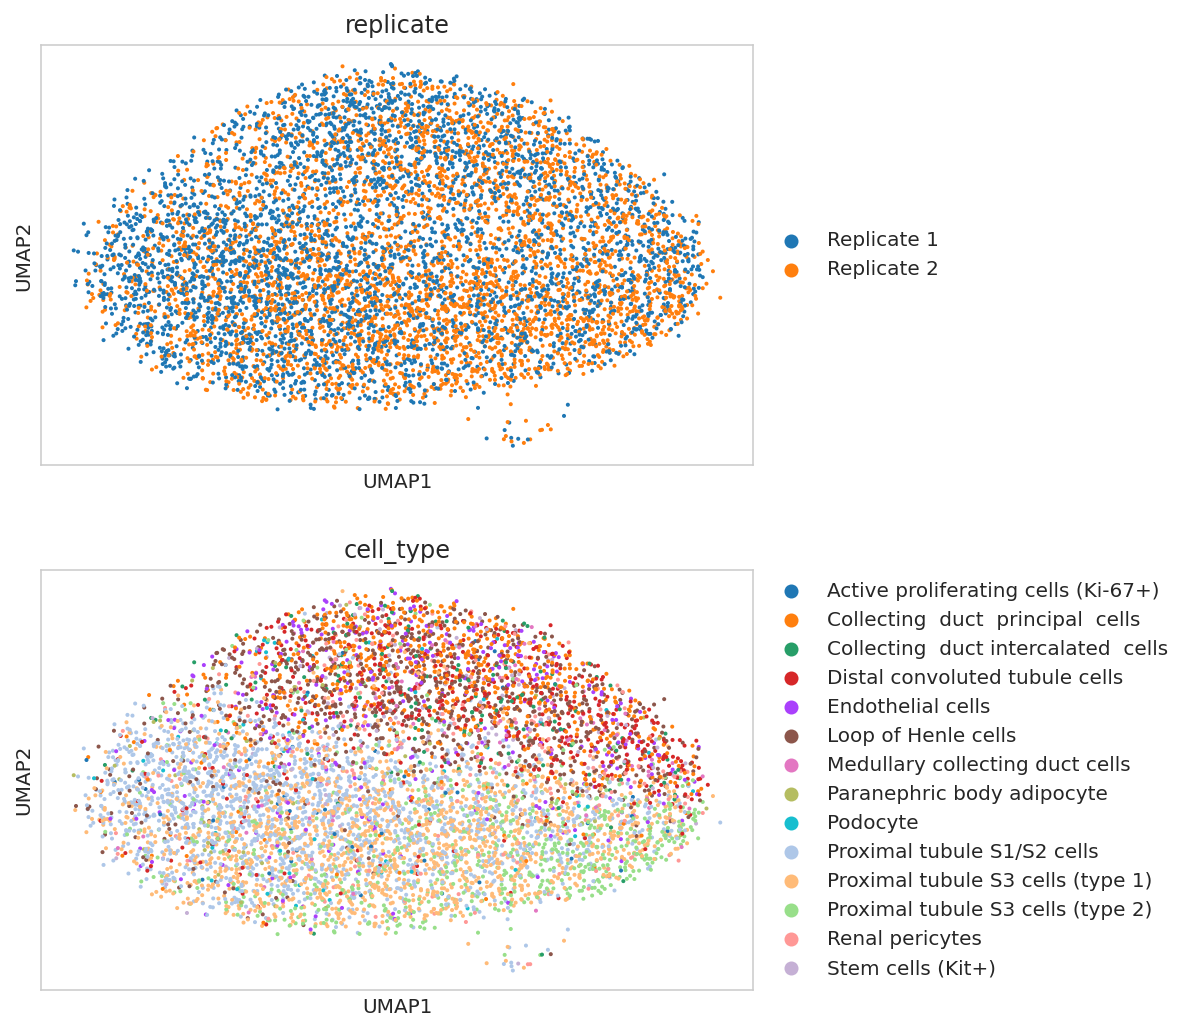

In [64]:
sc.pl.umap(scatac, color=['replicate', 'cell_type'], ncols=1)

---
# Save the results

### Find common paired samples

In [65]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(7362, 4000) (7362, 41524)


In [66]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 271 ms


In [67]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks.h5ad')

CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 421 ms
